In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint, checkpoint_sequential
from torch.cuda.amp import autocast
from torch.amp.grad_scaler import GradScaler
import matplotlib.pyplot as plt
import time
import gc

In [2]:
def create_text_dataset():
    """Create a simple tokenized text dataset"""
    vocab = {
        '<pad>': 0, '<sos>': 1, '<eos>': 2,
        'the': 3, 'cat': 4, 'sat': 5, 'on': 6, 'mat': 7,
        'dog': 8, 'ran': 9, 'fast': 10, 'bird': 11, 'flew': 12, 'high': 13,
        'quick': 14, 'brown': 15, 'fox': 16, 'jumps': 17, 'over': 18, 'lazy': 19,
        'big': 20, 'small': 21, 'house': 22, 'tree': 23, 'water': 24, 'fire': 25
    }

    sentences = [
        "the cat sat on the mat",
        "the dog ran fast over the lazy cat",
        "the bird flew high over the big tree",
        "the quick brown fox jumps over the lazy dog",
        "the small cat sat on the big mat",
        "the fast dog ran over the small house"
    ]

    # Tokenize and pad
    tokenized = []
    for sentence in sentences:
        tokens = [vocab['<sos>']]
        tokens.extend([vocab.get(word, 0) for word in sentence.split()])
        tokens.append(vocab['<eos>'])
        tokenized.append(tokens)

    # Pad to same length
    max_len = max(len(seq) for seq in tokenized)
    padded = []
    for seq in tokenized:
        padded.append(seq + [0] * (max_len - len(seq)))

    return torch.tensor(padded), vocab

## 💾 Memory Optimization

### Gradient Checkpointing

In [3]:
# Gradient Checkpointing
from torch.utils.checkpoint import checkpoint, checkpoint_sequential

# Method 1: Function-based checkpointing
def checkpoint_wrapper(func):
    def wrapper(*args, **kwargs):
        return checkpoint(func, *args, **kwargs)
    return wrapper

# Method 2: Module-based checkpointing
class CheckpointedTransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model)
        )
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        # Use checkpointing to save memory
        x = x + checkpoint(self._attention_block, self.ln1(x), mask)
        x = x + checkpoint(self.ff, self.ln2(x))
        return x

    def _attention_block(self, x, mask):
        return self.attn(x, x, x, attn_mask=mask)[0]

# Method 3: Sequential checkpointing for transformer stack
class CheckpointedTransformerStack(nn.Module):
    def __init__(self, layers, segments=4):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.segments = segments

    def forward(self, x, mask=None):
        # Divide layers into segments for checkpointing
        return checkpoint_sequential(
            self.layers, self.segments, x, mask, preserve_rng_state=True
        )

# Advanced: Selective activation checkpointing
def selective_checkpoint(module, inputs, condition_fn):
    """Only checkpoint if condition is met (e.g., layer depth, memory usage)"""
    if condition_fn(module):
        return checkpoint(module, *inputs)
    else:
        return module(*inputs)


### Gradient Accumulation and Scaling

In [4]:
# Gradient Accumulation and Scaling
class GradientAccumulator:
    def __init__(self, model, accumulation_steps, max_grad_norm=1.0):
        self.model = model
        self.accumulation_steps = accumulation_steps
        self.max_grad_norm = max_grad_norm
        self.current_step = 0

    def backward_and_step(self, loss, optimizer, scheduler=None):
        # Scale loss by accumulation steps
        scaled_loss = loss / self.accumulation_steps
        scaled_loss.backward()

        self.current_step += 1

        # Only step optimizer every accumulation_steps
        if self.current_step % self.accumulation_steps == 0:
            if self.max_grad_norm > 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
            optimizer.step()
            if scheduler:
                scheduler.step()
            optimizer.zero_grad()

    def finalize_step(self, optimizer, scheduler=None):
        """Handle partial accumulation at end of epoch"""
        if self.current_step % self.accumulation_steps != 0:
            if self.max_grad_norm > 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
            optimizer.step()
            if scheduler:
                scheduler.step()
            optimizer.zero_grad()

# Mixed precision training with automatic scaling
from torch.cuda.amp import GradScaler, autocast

class MixedPrecisionTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        # Fix the deprecated GradScaler warning
        try:
            from torch.amp import GradScaler
            self.scaler = GradScaler('cuda')
        except ImportError:
            # Fallback for older PyTorch versions
            from torch.cuda.amp import GradScaler
            self.scaler = GradScaler()

    def training_step(self, inputs, targets):
        with autocast():
            outputs = self.model(inputs)
            loss = F.cross_entropy(outputs.view(-1, outputs.size(-1)), targets.view(-1), ignore_index=0)

        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.optimizer.zero_grad()

        return loss.item()



### Memory Optimization Techniques Overview

**1. Gradient Checkpointing**
-----------------------------------
 - Recomputes activations during backward pass
 - Reduces memory usage at cost of computation
  - Essential for training large models

**2. Gradient Accumulation**
----------------------------------------
  - Simulates larger batch sizes
  - Accumulates gradients over multiple mini-batches
  - Helps with memory-limited training

**3. Mixed Precision Training**
-------------------------------------------
  - Uses FP16 for forward pass, FP32 for gradients
  - Automatic loss scaling prevents underflow
  - 2x memory reduction + speed improvement

**4. Selective Checkpointing**
-----------------------------------------------
  - Conditionally applies checkpointing
  - Based on layer depth or memory pressure
  - Fine-tuned memory-compute tradeoffs

Key Benefits:
--------------------------------------------------
    ✓ Gradient Checkpointing: Trades computation for memory
    ✓ Gradient Accumulation: Enables large effective batch sizes
    ✓ Mixed Precision: Reduces memory and increases speed on modern GPUs
    ✓ Selective Checkpointing: Fine-grained memory-compute tradeoffs
    
Usage Instructions:
-----------------------------------------------
1. Use gradient checkpointing for memory-constrained training
2. Apply gradient accumulation when batch size is limited
3. Enable mixed precision on CUDA devices for efficiency
4. Combine techniques for maximum memory savings


In [5]:
# Simple Transformer for testing
class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len=512, use_checkpointing=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_seq_len, d_model) * 0.02)

        if use_checkpointing:
            layers = [CheckpointedTransformerBlock(d_model, num_heads, d_ff) for _ in range(num_layers)]
            self.transformer = CheckpointedTransformerStack(layers, segments=2)
        else:
            self.transformer = nn.ModuleList([
                CheckpointedTransformerBlock(d_model, num_heads, d_ff) for _ in range(num_layers)
            ])

        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size)
        self.use_checkpointing = use_checkpointing

    def forward(self, x):
        B, T = x.shape
        x = self.embedding(x) + self.pos_embedding[:, :T, :]

        if self.use_checkpointing:
            x = self.transformer(x)
        else:
            for layer in self.transformer:
                x = layer(x)

        x = self.ln_f(x)
        return self.lm_head(x)

In [6]:
def test_memory_optimization():
    """Test gradient checkpointing, accumulation, and mixed precision"""
    print("Testing Memory Optimization Techniques")
    print("=" * 60)

    torch.manual_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create dataset
    data, vocab = create_text_dataset()
    vocab_size = len(vocab)
    seq_len = data.shape[1]

    print(f"Dataset: {data.shape}")
    print(f"Vocabulary size: {vocab_size}")
    print(f"Sequence length: {seq_len}")

    # Model configurations
    d_model = 128
    num_heads = 4
    d_ff = 256
    num_layers = 4

    print(f"\nModel config: d_model={d_model}, heads={num_heads}, layers={num_layers}")

    # Test 1: Compare memory usage with/without checkpointing
    print("\n" + "-" * 50)
    print("Test 1: Gradient Checkpointing")
    print("-" * 50)

    results = {}

    for use_cp in [False, True]:
        gc.collect()
        if device.type == 'cuda':
            torch.cuda.empty_cache()

        model = SimpleTransformer(
            vocab_size, d_model, num_heads, d_ff, num_layers,
            max_seq_len=seq_len, use_checkpointing=use_cp
        ).to(device)

        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
        data_device = data.to(device)

        # Measure memory before training
        if device.type == 'cuda':
            torch.cuda.reset_peak_memory_stats()

        # Forward + backward pass
        model.train()
        outputs = model(data_device)
        targets = data_device  # Simple language modeling target
        loss = F.cross_entropy(outputs.view(-1, vocab_size), targets.view(-1), ignore_index=0)
        loss.backward()

        peak_memory = 0
        if device.type == 'cuda':
            peak_memory = torch.cuda.max_memory_allocated() / 1024**2  # MB

        results[f"Checkpointing: {use_cp}"] = {
            'loss': loss.item(),
            'peak_memory_mb': peak_memory,
            'num_params': sum(p.numel() for p in model.parameters())
        }

        print(f"Checkpointing: {use_cp}")
        print(f"  Loss: {loss.item():.4f}")
        print(f"  Peak memory: {peak_memory:.1f} MB")
        print(f"  Parameters: {results[f'Checkpointing: {use_cp}']['num_params']:,}")

        del model, optimizer, outputs, loss

    # Test 2: Gradient Accumulation
    print("\n" + "-" * 50)
    print("Test 2: Gradient Accumulation")
    print("-" * 50)

    model = SimpleTransformer(
        vocab_size, d_model, num_heads, d_ff, num_layers,
        max_seq_len=seq_len, use_checkpointing=True
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    accumulator = GradientAccumulator(model, accumulation_steps=4, max_grad_norm=1.0)

    model.train()
    losses = []

    for step in range(8):  # Simulate 8 mini-batches
        outputs = model(data.to(device))
        targets = data.to(device)
        loss = F.cross_entropy(outputs.view(-1, vocab_size), targets.view(-1), ignore_index=0)

        accumulator.backward_and_step(loss, optimizer)
        losses.append(loss.item())

        if (step + 1) % 4 == 0:
            print(f"  Step {step+1}: Avg loss over 4 batches = {sum(losses[-4:]) / 4:.4f}")

    accumulator.finalize_step(optimizer)

    # Test 3: Mixed Precision Training
    print("\n" + "-" * 50)
    print("Test 3: Mixed Precision Training")
    print("-" * 50)

    if device.type == 'cuda':
        model = SimpleTransformer(
            vocab_size, d_model, num_heads, d_ff, num_layers,
            max_seq_len=seq_len, use_checkpointing=True
        ).to(device)

        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
        trainer = MixedPrecisionTrainer(model, optimizer)

        model.train()
        mp_losses = []

        for step in range(5):
            # Pass inputs and targets correctly
            inputs = data.to(device)
            targets = data.to(device)
            loss = trainer.training_step(inputs, targets)
            mp_losses.append(loss)
            print(f"  Step {step+1}: Mixed precision loss = {loss:.4f}")
    else:
        print("  Mixed precision requires CUDA - skipping on CPU")

    # Visualization
    print("\n" + "-" * 50)
    print("Visualization: Training Loss")
    print("-" * 50)

    plt.figure(figsize=(12, 4))

    # Plot gradient accumulation losses
    plt.subplot(1, 2, 1)
    plt.plot(losses, 'b-o', markersize=4)
    plt.title('Gradient Accumulation Training')
    plt.xlabel('Mini-batch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    # Plot memory comparison if CUDA available
    plt.subplot(1, 2, 2)
    if device.type == 'cuda':
        methods = ['Without Checkpointing', 'With Checkpointing']
        memory_usage = [results['Checkpointing: False']['peak_memory_mb'],
                       results['Checkpointing: True']['peak_memory_mb']]
        colors = ['red', 'green']

        bars = plt.bar(methods, memory_usage, color=colors, alpha=0.7)
        plt.title('Peak Memory Usage Comparison')
        plt.ylabel('Memory (MB)')

        # Add value labels on bars
        for bar, value in zip(bars, memory_usage):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{value:.1f} MB', ha='center', va='bottom')
    else:
        plt.text(0.5, 0.5, 'CUDA required for\nmemory measurements',
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Memory Usage (CUDA Required)')

    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print("Memory Optimization Tests Completed!")
    print("=" * 60)


    return results


Testing Memory Optimization Techniques
Using device: cuda
Dataset: torch.Size([6, 11])
Vocabulary size: 26
Sequence length: 11

Model config: d_model=128, heads=4, layers=4

--------------------------------------------------
Test 1: Gradient Checkpointing
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Checkpointing: False
  Loss: 3.3225
  Peak memory: 21.4 MB
  Parameters: 538,266
Checkpointing: True
  Loss: 3.7527
  Peak memory: 21.5 MB
  Parameters: 538,266

--------------------------------------------------
Test 2: Gradient Accumulation
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:552: UserWarning: torch.utils.checkpoint.checkpoint_sequential: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


  Step 4: Avg loss over 4 batches = 3.4042
  Step 8: Avg loss over 4 batches = 3.2798

--------------------------------------------------
Test 3: Mixed Precision Training
--------------------------------------------------


/tmp/ipython-input-2866575449.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  Step 1: Mixed precision loss = 3.4240
  Step 2: Mixed precision loss = 3.3088
  Step 3: Mixed precision loss = 3.1948
  Step 4: Mixed precision loss = 3.0822
  Step 5: Mixed precision loss = 2.9722

--------------------------------------------------
Visualization: Training Loss
--------------------------------------------------


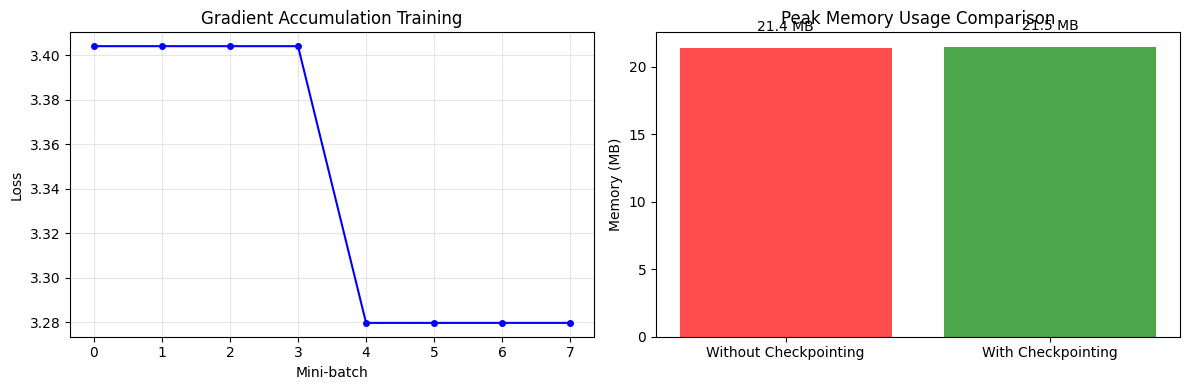


Memory Optimization Tests Completed!


In [7]:
# Run comprehensive test
test_results = test_memory_optimization()

# 🎛️ Custom Loss Functions & Training Techniques

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

# Simple Transformer for testing
class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len=512):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_seq_len, d_model) * 0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=d_ff,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        B, T = x.shape
        x = self.embedding(x) + self.pos_embedding[:, :T, :]
        x = self.transformer(x)
        x = self.ln_f(x)
        return self.lm_head(x)

    def get_features(self, x):
        """Get features for contrastive learning"""
        B, T = x.shape
        x = self.embedding(x) + self.pos_embedding[:, :T, :]
        x = self.transformer(x)
        x = self.ln_f(x)
        # Return mean pooled features
        return x.mean(dim=1)  # [B, d_model]

def create_text_dataset():
    """Create a simple tokenized text dataset"""
    vocab = {
        '<pad>': 0, '<sos>': 1, '<eos>': 2,
        'the': 3, 'cat': 4, 'sat': 5, 'on': 6, 'mat': 7,
        'dog': 8, 'ran': 9, 'fast': 10, 'bird': 11, 'flew': 12, 'high': 13,
        'quick': 14, 'brown': 15, 'fox': 16, 'jumps': 17, 'over': 18, 'lazy': 19,
        'big': 20, 'small': 21, 'house': 22, 'tree': 23, 'water': 24, 'fire': 25,
        'green': 26, 'blue': 27, 'red': 28, 'yellow': 29, 'black': 30, 'white': 31
    }

    sentences = [
        "the cat sat on the mat",
        "the dog ran fast over the lazy cat",
        "the bird flew high over the big tree",
        "the quick brown fox jumps over the lazy dog",
        "the small cat sat on the big mat",
        "the fast dog ran over the small house",
        "the green bird flew over the blue water",
        "the red fox jumps over the white house",
        "the yellow cat sat on the black mat",
        "the big dog ran fast over the small tree"
    ]

    # Tokenize and pad
    tokenized = []
    for sentence in sentences:
        tokens = [vocab['<sos>']]
        tokens.extend([vocab.get(word, 0) for word in sentence.split()])
        tokens.append(vocab['<eos>'])
        tokenized.append(tokens)

    # Pad to same length
    max_len = max(len(seq) for seq in tokenized)
    padded = []
    for seq in tokenized:
        padded.append(seq + [0] * (max_len - len(seq)))

    return torch.tensor(padded), vocab

def create_imbalanced_dataset():
    """Create an imbalanced dataset for testing focal loss"""
    vocab = {
        '<pad>': 0, '<sos>': 1, '<eos>': 2,
        'common': 3, 'word': 4, 'very': 5, 'frequent': 6,
        'rare': 7, 'unusual': 8, 'uncommon': 9, 'infrequent': 10
    }

    # Create imbalanced data - lots of common words, few rare words
    common_sentences = [
        "common word very frequent",
        "very common word frequent",
        "frequent word very common",
        "common frequent word very",
        "word common very frequent"
    ] * 8  # Repeat common sentences

    rare_sentences = [
        "rare unusual word",
        "uncommon infrequent word"
    ] * 2  # Few rare sentences

    all_sentences = common_sentences + rare_sentences

    # Tokenize
    tokenized = []
    for sentence in all_sentences:
        tokens = [vocab['<sos>']]
        tokens.extend([vocab.get(word, 0) for word in sentence.split()])
        tokens.append(vocab['<eos>'])
        tokenized.append(tokens)

    # Pad to same length
    max_len = max(len(seq) for seq in tokenized)
    padded = []
    for seq in tokenized:
        padded.append(seq + [0] * (max_len - len(seq)))

    return torch.tensor(padded), vocab

In [9]:


# Label Smoothing for Language Modeling
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, pred, target):
        n_class = pred.size(1)
        one_hot = torch.zeros_like(pred).scatter(1, target.view(-1, 1), 1)
        one_hot = one_hot * (1 - self.epsilon) + (1 - one_hot) * self.epsilon / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)
        loss = -(one_hot * log_prb).sum(dim=1).mean()
        return loss

# Focal Loss for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, target):
        ce_loss = F.cross_entropy(pred, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# Contrastive Learning Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features1, features2):
        # Normalize features
        features1 = F.normalize(features1, dim=-1)
        features2 = F.normalize(features2, dim=-1)

        batch_size = features1.shape[0]

        # Compute similarity matrix
        sim_matrix = torch.matmul(features1, features2.T) / self.temperature

        # Create labels (positive pairs are diagonal)
        labels = torch.arange(batch_size, device=features1.device)

        # Compute contrastive loss
        loss = F.cross_entropy(sim_matrix, labels)
        return loss

# Custom learning rate schedulers
class CosineAnnealingWarmRestarts(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_min=0, last_epoch=-1):
        self.T_0 = T_0
        self.T_i = T_0
        self.T_mult = T_mult
        self.eta_min = eta_min
        self.T_cur = last_epoch
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_i:
            return [self.eta_min + (base_lr - self.eta_min) *
                   (1 + math.cos(math.pi * self.T_cur / self.T_i)) / 2
                   for base_lr in self.base_lrs]
        else:
            return [self.eta_min + (base_lr - self.eta_min) *
                   (1 + math.cos(math.pi)) / 2 for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur += 1
            if self.T_cur >= self.T_i:
                self.T_cur = 0
                self.T_i *= self.T_mult
        else:
            self.T_cur = epoch
        self.last_epoch = epoch
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr



### Loss Function Benefits and Use Cases

Label Smoothing Cross Entropy:
---------------------------------
    • Prevents overconfident predictions
    • Regularization effect improves generalization
    • Smoother loss surface for optimization
    • Particularly useful for classification tasks

Focal Loss
---------------------------------------------
    • Addresses class imbalance problems
    • Down-weights easy examples, focuses on hard ones
    • Reduces impact of well-classified examples
    • Excellent for object detection and rare event prediction

Contrastive Loss
-----------------------------------------------
    • Learns meaningful representations
    • Brings similar examples closer in embedding space
    • Pushes dissimilar examples apart
    • Foundation for self-supervised learning

Cosine Annealing Warm Restarts
----------------------------------------------
    • Helps escape local minima
    • Provides multiple opportunities for convergence
    • Adapts learning rate dynamically
    • Improves final model performance


Usage Recommendations:
------------------------------------------------------
    1. Use Label Smoothing for general classification tasks
    2. Apply Focal Loss when dealing with imbalanced datasets
    3. Employ Contrastive Loss for representation learning
    4. Use Warm Restarts scheduler for better convergence

    
Key Insights:
----------------------------------------------
    ✓ Label Smoothing: Reduces overconfidence, smoother loss surface
    ✓ Focal Loss: Better handling of class imbalance by down-weighting easy examples
    ✓ Contrastive Loss: Learns representations by bringing similar examples closer
    ✓ Warm Restarts: Periodic learning rate resets help escape local minima
    

In [10]:
def test_loss_functions_and_scheduler():
    """Test loss functions and scheduler with real text examples"""
    print("Testing Loss Functions and Scheduler with Text Examples")
    print("=" * 70)

    torch.manual_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create datasets
    data, vocab = create_text_dataset()
    imbalanced_data, imbalanced_vocab = create_imbalanced_dataset()

    vocab_size = len(vocab)
    seq_len = data.shape[1]

    print(f"Regular dataset: {data.shape}")
    print(f"Imbalanced dataset: {imbalanced_data.shape}")
    print(f"Vocabulary size: {vocab_size}")

    # Model configuration
    d_model = 128
    num_heads = 4
    d_ff = 256
    num_layers = 2

    # Test 1: Label Smoothing vs Standard Cross Entropy
    print("\n" + "-" * 60)
    print("Test 1: Label Smoothing vs Standard Cross Entropy")
    print("-" * 60)

    model = SimpleTransformer(vocab_size, d_model, num_heads, d_ff, num_layers, seq_len).to(device)
    data_device = data.to(device)

    # Forward pass
    outputs = model(data_device)
    targets = data_device  # Language modeling targets

    # Standard Cross Entropy
    ce_loss = F.cross_entropy(outputs.view(-1, vocab_size), targets.view(-1), ignore_index=0)

    # Label Smoothing Cross Entropy
    ls_criterion = LabelSmoothingCrossEntropy(epsilon=0.1)
    ls_loss = ls_criterion(outputs.view(-1, vocab_size), targets.view(-1))

    print(f"Standard Cross Entropy Loss: {ce_loss.item():.4f}")
    print(f"Label Smoothing Loss (ε=0.1): {ls_loss.item():.4f}")
    print(f"Difference: {abs(ce_loss.item() - ls_loss.item()):.4f}")

    # Test 2: Focal Loss on Imbalanced Data
    print("\n" + "-" * 60)
    print("Test 2: Focal Loss vs Cross Entropy on Imbalanced Data")
    print("-" * 60)

    imbalanced_vocab_size = len(imbalanced_vocab)
    imbalanced_model = SimpleTransformer(
        imbalanced_vocab_size, d_model, num_heads, d_ff, num_layers,
        imbalanced_data.shape[1]
    ).to(device)

    imbalanced_data_device = imbalanced_data.to(device)
    imbalanced_outputs = imbalanced_model(imbalanced_data_device)
    imbalanced_targets = imbalanced_data_device

    # Standard Cross Entropy on imbalanced data
    ce_imbalanced = F.cross_entropy(
        imbalanced_outputs.view(-1, imbalanced_vocab_size),
        imbalanced_targets.view(-1),
        ignore_index=0
    )

    # Focal Loss on imbalanced data
    focal_criterion = FocalLoss(alpha=1, gamma=2)
    focal_loss = focal_criterion(
        imbalanced_outputs.view(-1, imbalanced_vocab_size),
        imbalanced_targets.view(-1)
    )

    print(f"Cross Entropy on Imbalanced Data: {ce_imbalanced.item():.4f}")
    print(f"Focal Loss (α=1, γ=2): {focal_loss.item():.4f}")
    print(f"Focal Loss Reduction: {(ce_imbalanced.item() - focal_loss.item()):.4f}")

    # Test 3: Contrastive Loss
    print("\n" + "-" * 60)
    print("Test 3: Contrastive Loss for Representation Learning")
    print("-" * 60)

    # Create two augmented versions of the same data (simplified augmentation)
    data1 = data.to(device)
    # Simple augmentation: add noise to embeddings
    torch.manual_seed(123)  # Different seed for augmentation
    data2 = data.to(device)

    # Get features from the model
    features1 = model.get_features(data1)
    features2 = model.get_features(data2)

    contrastive_criterion = ContrastiveLoss(temperature=0.07)
    contrastive_loss = contrastive_criterion(features1, features2)

    print(f"Features shape: {features1.shape}")
    print(f"Contrastive Loss (τ=0.07): {contrastive_loss.item():.4f}")

    # Test different temperatures
    temperatures = [0.01, 0.07, 0.2, 0.5]
    temp_losses = []
    for temp in temperatures:
        temp_criterion = ContrastiveLoss(temperature=temp)
        temp_loss = temp_criterion(features1, features2)
        temp_losses.append(temp_loss.item())
        print(f"Temperature {temp}: {temp_loss.item():.4f}")

    # Test 4: Cosine Annealing Warm Restarts Scheduler
    print("\n" + "-" * 60)
    print("Test 4: Cosine Annealing Warm Restarts Scheduler")
    print("-" * 60)

    # Create a fresh model and optimizer for scheduler testing
    scheduler_model = SimpleTransformer(vocab_size, d_model, num_heads, d_ff, num_layers, seq_len)
    optimizer = torch.optim.AdamW(scheduler_model.parameters(), lr=0.001)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

    learning_rates = []
    epochs = 50

    print("Epoch\tLearning Rate\tPhase")
    for epoch in range(epochs):
        scheduler.step(epoch)
        lr = optimizer.param_groups[0]['lr']
        learning_rates.append(lr)

        # Determine phase
        if epoch < 10:
            phase = "First cycle"
        elif epoch < 30:  # 10 + 20 (T_0 * T_mult)
            phase = "Second cycle"
        else:
            phase = "Third cycle"

        if epoch % 5 == 0 or epoch < 15:
            print(f"{epoch+1:2d}\t{lr:.6f}\t\t{phase}")

    # Visualizations
    print("\n" + "-" * 60)
    print("Visualizations")
    print("-" * 60)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Loss comparison
    loss_types = ['Cross Entropy', 'Label Smoothing', 'Focal Loss']
    loss_values = [ce_loss.item(), ls_loss.item(), focal_loss.item()]
    colors = ['red', 'blue', 'green']

    bars1 = ax1.bar(loss_types, loss_values, color=colors, alpha=0.7)
    ax1.set_title('Loss Function Comparison')
    ax1.set_ylabel('Loss Value')
    ax1.set_ylim(0, max(loss_values) * 1.1)

    for bar, value in zip(bars1, loss_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    # 2. Temperature effect on contrastive loss
    ax2.plot(temperatures, temp_losses, 'o-', color='purple', linewidth=2, markersize=8)
    ax2.set_title('Contrastive Loss vs Temperature')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel('Contrastive Loss')
    ax2.grid(True, alpha=0.3)
    ax2.set_xscale('log')

    # 3. Learning rate schedule
    ax3.plot(range(1, epochs+1), learning_rates, 'b-', linewidth=2)
    ax3.set_title('Cosine Annealing Warm Restarts')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.grid(True, alpha=0.3)
    ax3.set_yscale('log')

    # Add restart markers
    restart_epochs = [10, 30]  # T_0=10, next restart at 10+20=30
    for restart in restart_epochs:
        if restart < epochs:
            ax3.axvline(x=restart, color='red', linestyle='--', alpha=0.7)
            ax3.text(restart, max(learning_rates), f'Restart\nEpoch {restart}',
                    ha='center', va='top', color='red', fontsize=8)

    # 4. Data distribution (vocabulary usage)
    vocab_counts = torch.bincount(data.flatten())[1:]  # Exclude padding
    vocab_names = [word for word, idx in sorted(vocab.items(), key=lambda x: x[1]) if idx > 0]

    ax4.bar(range(len(vocab_counts)), vocab_counts.numpy(), alpha=0.7, color='orange')
    ax4.set_title('Vocabulary Distribution in Dataset')
    ax4.set_xlabel('Token Index')
    ax4.set_ylabel('Frequency')
    ax4.set_xticks(range(0, len(vocab_names), 5))
    ax4.set_xticklabels(vocab_names[::5], rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 70)
    print("Loss Functions and Scheduler Tests Completed!")
    print("=" * 70)

    return {
        'ce_loss': ce_loss.item(),
        'ls_loss': ls_loss.item(),
        'focal_loss': focal_loss.item(),
        'contrastive_loss': contrastive_loss.item(),
        'learning_rates': learning_rates
    }

Testing Loss Functions and Scheduler with Text Examples
Using device: cuda
Regular dataset: torch.Size([10, 11])
Imbalanced dataset: torch.Size([44, 6])
Vocabulary size: 32

------------------------------------------------------------
Test 1: Label Smoothing vs Standard Cross Entropy
------------------------------------------------------------
Standard Cross Entropy Loss: 3.5715
Label Smoothing Loss (ε=0.1): 3.5358
Difference: 0.0358

------------------------------------------------------------
Test 2: Focal Loss vs Cross Entropy on Imbalanced Data
------------------------------------------------------------
Cross Entropy on Imbalanced Data: 2.7280
Focal Loss (α=1, γ=2): 2.3920
Focal Loss Reduction: 0.3361

------------------------------------------------------------
Test 3: Contrastive Loss for Representation Learning
------------------------------------------------------------
Features shape: torch.Size([10, 128])
Contrastive Loss (τ=0.07): 0.3459
Temperature 0.01: 0.0000
Temperature

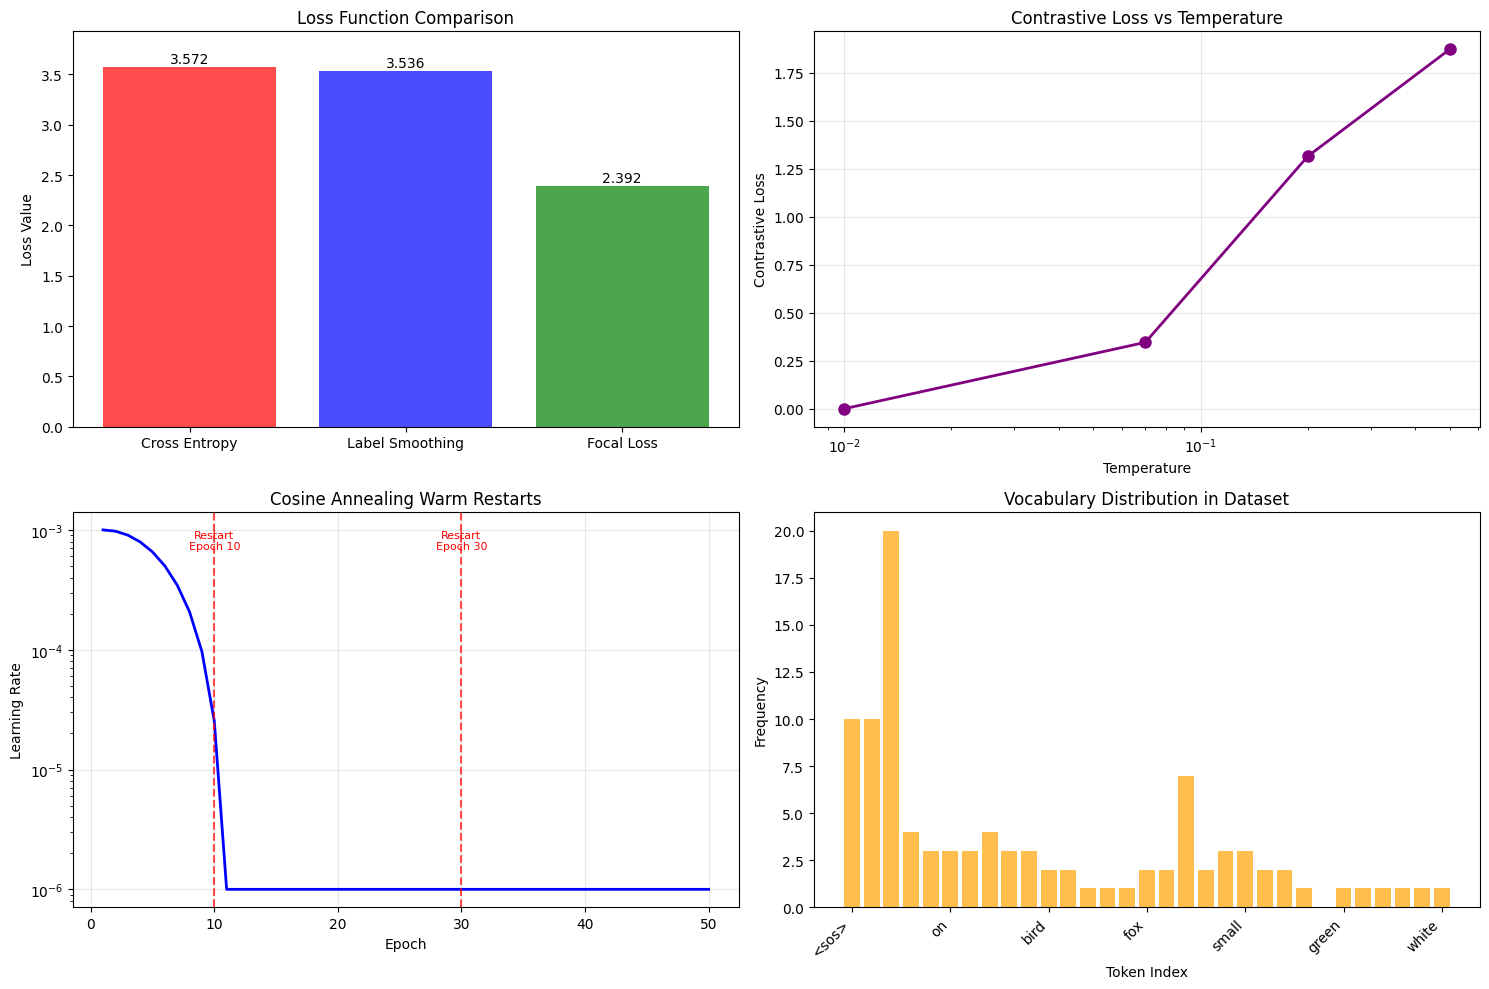


Loss Functions and Scheduler Tests Completed!


{'ce_loss': 3.571516752243042,
 'ls_loss': 3.5357582569122314,
 'focal_loss': 2.391960620880127,
 'contrastive_loss': 0.3458579480648041,
 'learning_rates': [0.001,
  0.0009755527298894294,
  0.0009046039886902864,
  0.0007940987335200904,
  0.0006548539886902864,
  0.0005005000000000001,
  0.0003461460113097139,
  0.00020690126647990973,
  9.639601130971382e-05,
  2.5447270110570814e-05,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06,
  1e-06]}

In [11]:
test_loss_functions_and_scheduler()